## Part 3: Modeling and Model Selection

I am trying to compare the <mark>*Random Forest, Logistic Regression, Support Vector Machine, and Multinomial Naive Bayes*</mark> models and will select the one with best accuracy score.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, plot_roc_curve, roc_auc_score, recall_score, precision_score, f1_score
from sklearn.svm import SVC


In [2]:
# import cleaned comments data from csv
df = pd.read_csv('./submision/comments_clean.csv')
df.head()

,body,length,word_count,target
0,typically hosting centralized service and mere...,186,30,1
1,yup feast for,25,6,1
2,4000 you kidding right the floor bored ape lik...,68,13,1
3,prognosis negative someone dropped fucking jun...,72,11,1
4,nano but for monkey,22,4,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3232 entries, 0 to 3231
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   body        3232 non-null   object
 1   length      3232 non-null   int64 
 2   word_count  3232 non-null   int64 
 3   target      3232 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 101.1+ KB


### set up X and y, train/test split

In [4]:
X = df['body']
y = df['target']

y.value_counts(normalize=True) # baseline accuracy



1    0.541151
0    0.458849
Name: target, dtype: float64

In [5]:
# train/test split
# stratify y just in case, even though the classes are balanced
# test_size : default = 0.25
# shuffle: default = True

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    stratify=y, #to keep the same balance of y in the test and train data
                                                    random_state=42)

In [6]:
X_train.shape

(2424,)

In [7]:
X_test.shape

(808,)

In [8]:
y_train.shape

(2424,)

In [9]:
y_test.shape

(808,)

## Model x1-1: CountVectorizer & Logistic Regression

In [10]:
# set a pipeline up with two stages:
# 1. CountVectorizer (transformer)
# 2. LogisticRegression (estimator)

pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression())
])

# Search over the following values of hyperparameters:
# Maximum number of features fit: 5000, 10,000, 15,000
# Minimum number of documents needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
# Check (individual tokens) and also check (individual tokens and 2-grams).

pipe_params = {
    'cvec__max_features' : [5_000, 10_000, 15_000],
    'cvec__min_df' : [2,3],
    'cvec__max_df': [0.9, 0.95],
    'cvec__ngram_range' : [(1,1), (1,2)]
}

# Instantiate GridSearchCV.

gs1 = GridSearchCV(pipe, # what object are we optimizing?
                  param_grid = pipe_params, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.

In [11]:
# Fit GridSearch to training data.
gs1.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('lr', LogisticRegression())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [5000, 10000, 15000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)]})

In [12]:
# What's the best score?
gs1.best_score_

0.681104200391923

In [13]:
gs1.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 5000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1)}

In [14]:
# Save best model as gs_model.

gs_model = gs1.best_estimator_
# Score model on training set.
print(f'Train score is {gs_model.score(X_train, y_train)}')
# Score model on testing set.
print(f'Test score is {gs_model.score(X_test, y_test)}')

Train score is 0.9240924092409241
Test score is 0.7351485148514851


In [15]:
gs1_preds = gs1.predict(X_test)
print(f'Accuracy:{gs1.score(X_train,y_train), gs1.score(X_test,y_test)}, Recall:{recall_score(y_test,gs1_preds)}, Precision:{precision_score(y_test,gs1_preds)}, F1:{f1_score(y_test,gs1_preds)}')


Accuracy:(0.9240924092409241, 0.7351485148514851), Recall:0.8123569794050344, Precision:0.728952772073922, F1:0.7683982683982684


## Model x1-2: TF - IDF Vectorizer & Logistic Regression

In [16]:
pipe2 = Pipeline([
                ('tf', TfidfVectorizer()),
                ('lr', LogisticRegression())
])

params2 = {
                'tf__max_features' : [5000,10_000,15_000],
                'tf__ngram_range' : [(1,1), (1,2)]
}

gs2 = GridSearchCV(pipe2, param_grid = params2, cv = 5)

In [17]:
gs2.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tf', TfidfVectorizer()),
                                       ('lr', LogisticRegression())]),
             param_grid={'tf__max_features': [5000, 10000, 15000],
                         'tf__ngram_range': [(1, 1), (1, 2)]})

In [18]:
# What's the best score?
gs2.best_score_

0.7112217772855074

In [19]:
gs2.best_params_

{'tf__max_features': 5000, 'tf__ngram_range': (1, 1)}

In [20]:
# Save best model as gs_model.

gs_model = gs2.best_estimator_

In [21]:
gs2_preds = gs2.predict(X_test)
print(f'Accuracy:{gs2.score(X_train,y_train), gs2.score(X_test,y_test)}, Recall:{recall_score(y_test,gs2_preds)}, Precision:{precision_score(y_test,gs2_preds)}, F1:{f1_score(y_test,gs2_preds)}')


Accuracy:(0.9088283828382838, 0.7438118811881188), Recall:0.8306636155606407, Precision:0.7318548387096774, F1:0.7781350482315113


In [22]:
# Score model on training set.
print(f'Train score is {gs_model.score(X_train, y_train)}')
# Score model on testing set.
print(f'Test score is {gs_model.score(X_test, y_test)}')

Train score is 0.9088283828382838
Test score is 0.7438118811881188


In [23]:
y_pred = gs2.predict(X_test)
cm_def = np.array([['True Negative', 'False Positive'],
                ['False Negative', 'True Positive']])
cm_def = pd.DataFrame(cm_def,columns = ['pred neg', 'pred pos'], index = ['actual neg','actual pos'])
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, columns = ['pred neg', 'pred pos'], index = ['actual neg','actual pos'])
display(cm_def)
display(cm_df)

,pred neg,pred pos
actual neg,True Negative,False Positive
actual pos,False Negative,True Positive


,pred neg,pred pos
actual neg,238,133
actual pos,74,363


## Model x2-1: CountVectorizer & Random Forest Classifier

In [24]:
pipe = Pipeline([
                ('cvec', CountVectorizer()),
                ('rf', RandomForestClassifier())
])

pipe_params = {
     'cvec__max_features' : [5_000, 10_000, 15_000],
    'cvec__min_df' : [2,3],
    'cvec__max_df': [0.9, 0.95],
    'cvec__ngram_range' : [(1,1), (1,2)]
}


gs3 = GridSearchCV(pipe, param_grid = pipe_params, cv = 5)

In [25]:
# Fit GridSearch to training data.
gs3.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [5000, 10000, 15000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)]})

In [26]:
# What's the best score?
gs3.best_score_

0.6670784697963704

In [27]:
gs3.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 15000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2)}

In [28]:
print(gs3.best_params_)
gs_model = gs3.best_estimator_

gs_train_accuracy = round(gs_model.score(X_train, y_train),2)
print(f'Train Accuracy: {gs_train_accuracy}')

gs_test_accuracy = round(gs_model.score(X_test, y_test),2)
print(f'Test Accuracy: {gs_test_accuracy}')

{'cvec__max_df': 0.9, 'cvec__max_features': 15000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2)}
Train Accuracy: 0.99
Test Accuracy: 0.7


In [29]:
gs3_preds = gs3.predict(X_test)
print(f'Accuracy:{gs3.score(X_train,y_train), gs3.score(X_test,y_test)}, Recall:{recall_score(y_test,gs3_preds)}, Precision:{precision_score(y_test,gs3_preds)}, F1:{f1_score(y_test,gs3_preds)}')


Accuracy:(0.9863861386138614, 0.6955445544554455), Recall:0.8237986270022883, Precision:0.6805293005671077, F1:0.7453416149068324


In [30]:
y_pred = gs3.predict(X_test)
cm_def = np.array([['True Negative', 'False Positive'],
                ['False Negative', 'True Positive']])
cm_def = pd.DataFrame(cm_def,columns = ['pred neg', 'pred pos'], index = ['actual neg','actual pos'])
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, columns = ['pred neg', 'pred pos'], index = ['actual neg','actual pos'])
display(cm_def)
display(cm_df)

,pred neg,pred pos
actual neg,True Negative,False Positive
actual pos,False Negative,True Positive


,pred neg,pred pos
actual neg,202,169
actual pos,77,360


## Model x2-2: TFIDF and Random Forest Classifer

In [31]:
pipe = Pipeline([
                ('tf', TfidfVectorizer()),
                ('rf', RandomForestClassifier())
])

params = {
                'tf__max_features' : [5000,10_000,15_000],
                'tf__ngram_range' : [(1,1), (1,2)]
}


gs4 = GridSearchCV(pipe, param_grid = params, cv = 5)

In [32]:
gs4.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tf', TfidfVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             param_grid={'tf__max_features': [5000, 10000, 15000],
                         'tf__ngram_range': [(1, 1), (1, 2)]})

In [33]:
print(gs4.best_params_)
gs_model = gs4.best_estimator_

gs_train_accuracy = round(gs_model.score(X_train, y_train),2)
print(f'Train Accuracy: {gs_train_accuracy}')

gs_test_accuracy = round(gs_model.score(X_test, y_test),2)
print(f'Test Accuracy: {gs_test_accuracy}')

{'tf__max_features': 5000, 'tf__ngram_range': (1, 1)}
Train Accuracy: 1.0
Test Accuracy: 0.67


In [34]:
gs4_preds = gs4.predict(X_test)
print(f'Accuracy:{gs4.score(X_train,y_train), gs4.score(X_test,y_test)}, Recall:{recall_score(y_test,gs4_preds)}, Precision:{precision_score(y_test,gs4_preds)}, F1:{f1_score(y_test,gs4_preds)}')


Accuracy:(0.995049504950495, 0.6720297029702971), Recall:0.7276887871853547, Precision:0.6853448275862069, F1:0.7058823529411764


In [35]:
##### y_pred = gs4.predict(X_test)
cm_def = np.array([['True Negative', 'False Positive'],
                ['False Negative', 'True Positive']])
cm_def = pd.DataFrame(cm_def,columns = ['pred neg', 'pred pos'], index = ['actual neg','actual pos'])
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, columns = ['pred neg', 'pred pos'], index = ['actual neg','actual pos'])
display(cm_def)
display(cm_df)

,pred neg,pred pos
actual neg,True Negative,False Positive
actual pos,False Negative,True Positive


,pred neg,pred pos
actual neg,202,169
actual pos,77,360


## Model 3: TFIDF and Support Vector Machine Classifier

In [36]:
pipe = Pipeline([
                ('tf', TfidfVectorizer()),
                ('svc', SVC())
])

params = {
                'tf__max_features' : [5000,10_000,15_000],
                'tf__ngram_range' : [(1,1), (1,2)]
}


gs5 = GridSearchCV(pipe, param_grid = params, cv = 5)

In [37]:
gs5.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tf', TfidfVectorizer()),
                                       ('svc', SVC())]),
             param_grid={'tf__max_features': [5000, 10000, 15000],
                         'tf__ngram_range': [(1, 1), (1, 2)]})

In [38]:
print(gs5.best_params_)
gs_model = gs5.best_estimator_

gs_train_accuracy = round(gs_model.score(X_train, y_train),2)
print(f'Train Accuracy: {gs_train_accuracy}')

gs_test_accuracy = round(gs_model.score(X_test, y_test),2)
print(f'Test Accuracy: {gs_test_accuracy}')

{'tf__max_features': 5000, 'tf__ngram_range': (1, 1)}
Train Accuracy: 0.98
Test Accuracy: 0.74


In [39]:
gs5_preds = gs5.predict(X_test)
print(f'Accuracy:{gs5.score(X_train,y_train), gs5.score(X_test,y_test)}, Recall:{recall_score(y_test,gs5_preds)}, Precision:{precision_score(y_test,gs5_preds)}, F1:{f1_score(y_test,gs5_preds)}')


Accuracy:(0.9847359735973598, 0.7413366336633663), Recall:0.8100686498855835, Precision:0.7375, F1:0.7720828789531079


In [40]:
y_pred = gs5.predict(X_test)
cm_def = np.array([['True Negative', 'False Positive'],
                ['False Negative', 'True Positive']])
cm_def = pd.DataFrame(cm_def,columns = ['pred neg', 'pred pos'], index = ['actual neg','actual pos'])
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, columns = ['pred neg', 'pred pos'], index = ['actual neg','actual pos'])
display(cm_def)
display(cm_df)

,pred neg,pred pos
actual neg,True Negative,False Positive
actual pos,False Negative,True Positive


,pred neg,pred pos
actual neg,245,126
actual pos,83,354


## Model 4: CountVectorizer & Multinomial Naive Bayes

In [41]:
# set a pipeline up with two stages:
# 1. CountVectorizer (transformer)
# 2. Naive Bayes (estimator)

pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

# Search over the following values of hyperparameters:
# Maximum number of features fit: 5000, 10,000, 15,000
# Minimum number of documents needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
# Check (individual tokens) and also check (individual tokens and 2-grams).

pipe_params = {
    'cvec__max_features' : [5_000, 10_000, 15_000],
    'cvec__min_df' : [2,3],
    'cvec__max_df': [0.9, 0.95],
    'cvec__ngram_range' : [(1,1), (1,2)]
}

# Instantiate GridSearchCV.

gs6 = GridSearchCV(pipe, # what object are we optimizing?
                  param_grid = pipe_params, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.

In [42]:
# Fit GridSearch to training data.
gs6.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [5000, 10000, 15000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)]})

In [43]:
# What are the best hyperparameters?
gs6.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 5000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1)}

In [44]:
# What's the best score?
gs6.best_score_

0.7149390815370197

In [45]:
# Score model on training set.
gs6.score(X_train, y_train)

0.8502475247524752

In [46]:
# Score model on testing set.
gs6.score(X_test, y_test)

0.7227722772277227

**misclassification = 1 - accuracy**

In [47]:
# training data missclassification
1- gs6.score(X_train, y_train)

0.14975247524752477

In [48]:
# testing data missclassification
1- gs6.score(X_test, y_test)

0.27722772277227725

In [49]:
gs6_preds = gs6.predict(X_test)
print(f'Accuracy:{gs6.score(X_train,y_train), gs6.score(X_test,y_test)}, Recall:{recall_score(y_test,gs6_preds)}, Precision:{precision_score(y_test,gs6_preds)}, F1:{f1_score(y_test,gs6_preds)}')


Accuracy:(0.8502475247524752, 0.7227722772277227), Recall:0.7688787185354691, Precision:0.7320261437908496, F1:0.7500000000000001


In [50]:
# Score model on training set.
print(f'Train score is {gs6.score(X_train, y_train)}')
# Score model on testing set.
print(f'Test score is {gs6.score(X_test, y_test)}')

Train score is 0.8502475247524752
Test score is 0.7227722772277227


* So, accuracy may is not the best scorew

In [51]:
y_pred = gs6.predict(X_test)
cm_def = np.array([['True Negative', 'False Positive'],
                ['False Negative', 'True Positive']])
cm_def = pd.DataFrame(cm_def,columns = ['pred neg', 'pred pos'], index = ['actual neg','actual pos'])
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, columns = ['pred neg', 'pred pos'], index = ['actual neg','actual pos'])
display(cm_def)
display(cm_df)

,pred neg,pred pos
actual neg,True Negative,False Positive
actual pos,False Negative,True Positive


,pred neg,pred pos
actual neg,248,123
actual pos,101,336


In [52]:
# Get predictions
preds_tvec = gs6.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds_tvec).ravel()

# Calculate the specificity and precision

spec = tn / (tn + fp)
prec = tp / (tp + fp)

print('Specificity:', spec)
print('Precision:', prec)

Specificity: 0.6684636118598383
Precision: 0.7320261437908496


## model Selection

### Putting all my models together:

|Model classifier| Training Score| Testing Score| Recall|Precision|F1|
|--|--|--|--|--|--|
|CountVectorizer & Logistic Regression|0.924|0.735|0.8124|0.7290|0.7684|
|TF - IDF Vectorizer & Logistic Regression|<mark>0.9088</mark>|<mark>0.744</mark>|<mark>0.8304</mark>|<mark>0.7319</mark>|<mark>0.7781</mark>|
|CountVectorizer & Random Forest Classifier|0.9864|0.6956|0.8238|0.6805|0.7453|
|TFIDF and Random Forest Classifer|0.9951|0.6720|0.7277|0.6854|0.7059|
|TFIDF and Support Vector Machine Classifier|0.9847|0.7413|0.8101|0.7375|0.7721|
|CountVectorizer & Multinomial Naive Bayes|<mark>0.8502</mark>|<mark>0.7228</mark>|<mark>0.7689</mark>|<mark>0.7320</mark>|<mark>0.7500</mark>|

Although the MultinomialNB looks less overfitting, I am choosing TF - IDF Vectorizer & Logistic Regression since it has better accuracy based on my [reference](https://datascience.stackexchange.com/questions/53256/how-to-know-if-a-model-is-overfitting-or-underfitting-by-looking-at-graph):
  > Overfitting is easy to diagnose with the accuracy visualizations you have available. If "Accuracy" (measured against the training set) is very good and "Validation Accuracy" (measured against a validation set) is not as good, then your model is overfitting.

### The Model TF - IDF Vectorizer & Logistic Regression is the best model to be selected for this project

So, putting everything altogether:

In [53]:
# copying my previous work

gs_model = gs2.best_estimator_

In [54]:
gs2_preds = gs2.predict(X_test)
print(f'Accuracy:{gs2.score(X_train,y_train), gs2.score(X_test,y_test)}, Recall:{recall_score(y_test,gs2_preds)}, Precision:{precision_score(y_test,gs2_preds)}, F1:{f1_score(y_test,gs2_preds)}')


Accuracy:(0.9088283828382838, 0.7438118811881188), Recall:0.8306636155606407, Precision:0.7318548387096774, F1:0.7781350482315113


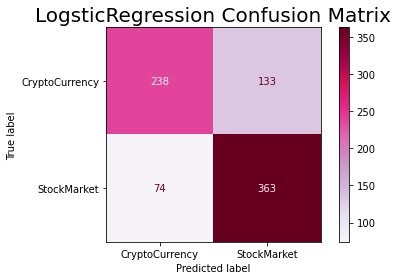

In [55]:
tn, fp, fn, tp = confusion_matrix(y_test, gs2_preds).ravel()
plot_confusion_matrix(gs_model,X_test,y_test, 
                      display_labels=['CryptoCurrency', 'StockMarket'],
                     cmap='PuRd');
plt.title('LogsticRegression Confusion Matrix',size=20);
plt.tight_layout();
#plt.savefig('./imgs/cm_4best_model.png');

In [56]:

# Score model on training set.
print(f'Train score is {gs_model.score(X_train, y_train)}')
# Score model on testing set.
print(f'Test score is {gs_model.score(X_test, y_test)}')



Train score is 0.9088283828382838
Test score is 0.7438118811881188


In [57]:
y_pred = gs2.predict(X_test)
cm_def = np.array([['True Negative', 'False Positive'],
                ['False Negative', 'True Positive']])
cm_def = pd.DataFrame(cm_def,columns = ['pred neg', 'pred pos'], index = ['actual neg','actual pos'])
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, columns = ['pred neg', 'pred pos'], index = ['actual neg','actual pos'])
display(cm_def)
display(cm_df)

,pred neg,pred pos
actual neg,True Negative,False Positive
actual pos,False Negative,True Positive


,pred neg,pred pos
actual neg,238,133
actual pos,74,363


In [58]:
# Get predictions
preds = gs2.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

# Calculate the specificity and precision

spec = tn / (tn + fp)
prec = tp / (tp + fp)
acc = (tp + tn)/(tp + tn + fp + fn)
sens = tp/(tp+fn)

print('Specificity:', spec)
print('Precision:', prec)
print('Sensitivty:', sens)
print('Accuracy:', acc)

Specificity: 0.6415094339622641
Precision: 0.7318548387096774
Sensitivty: 0.8306636155606407
Accuracy: 0.7438118811881188


With my crypto as actual positive, and stock as negative, my confusion matrix looks like:
    
||Predicted Negative|Predicted Positive|   
|---|---|---|
|Actual Negative|TN|<mark>FP</mark>|
|Actual Positive|<mark>FN</mark>|TP|


||Predicted Negative|Predicted Positive|   
|---|---|---|
|Stock|TN|<mark>133</mark>|
|Crypto|<mark>74</mark>|TP|

Specificity: spec = tn / (tn + fp) = 0.6415

⇢ the model predicted 64.15% of the posts belong to the stock market subreddit

⇢ Type I Error ( or FP)  = 1- spec = 0.3585 

* the model incorrectly predicted 35.85% of the post as cryptocurrency subreddit

Sensitivity: sens = tp/(tp+fn) = 0.8307

⇢ the model correctly predicted 83.07% of the posts belong to the cryptocurrency subreddit

⇢ Type II Error ( or FN)  = 1- sens = 0.1693

* the model incorrectly predicted 16.93% of the post as StockMarket subreddit

Accuracy: acc = (tp + tn)/(tp + tn + fp + fn) = 0.7438

⇢ the model predicted 74.38% of the posts correct


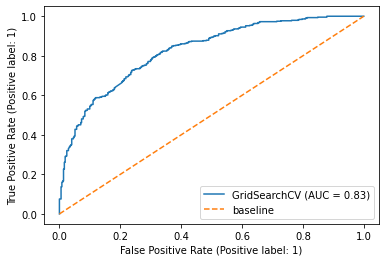

In [59]:

pipe2 = Pipeline([
                ('tf', TfidfVectorizer()),
                ('lr', LogisticRegression())
])

params2 = {
                'tf__max_features' : [5000,10_000,15_000],
                'tf__ngram_range' : [(1,1), (1,2)]
}

gs2 = GridSearchCV(pipe2, param_grid = params2, cv = 5)

gs2.fit(X_train, y_train)

# ROC curve
plot_roc_curve(gs2, X_test, y_test)

# add worst case scenario line
plt.plot([0, 1], [0, 1], label="baseline", linestyle="--")

# add a legend
plt.legend();

I  want see the blue curve to be as close as possible to a square corner, thus making the area under the curve as close to 1 as possible, but it’s far but not bad.

False positive rate = type I error 

1 − specificity

= FP / (FP + TN
            




False  negative rate = type II error

   = 1 − sensitivity
   
   = FN / (TP + FN)

The ROC curve is a plot of the True Positive Rate (sensitivity) vs. the False Positive Rate (1 - specificity) for all possible decision thresholds.

* ROC is a plot of signal (True Positive Rate) against noise (False Positive Rate). ... The model performance is determined by looking at the area under the ROC curve (or AUC).


### Conclusions and Recommendations


* My Best scoring model: Logistic regression, Train / test score: 0.9089/0.7438
* Potential improvements: collect more training data, do more data cleaning and preprocessing (remove more stop words i.e., numbers, stem/lemmatize i.e. -ing verbs), more intensive gridsearching to optimize models, try more models (boosting, SVM) 

**>> Steps Forward**:

Getting real-time data using webscraping of the subreddits, make fresh predictions and make Sentiment Analysis.


References:

* [Is your model overfitting? Or maybe underfitting? An example using a neural network](https://towardsdatascience.com/is-your-model-overfitting-or-maybe-underfitting-an-example-using-a-neural-network-in-python-4faf155398d2)
* [How to Identify Overfitting Machine Learning Models in Scikit-Learn](https://machinelearningmastery.com/overfitting-machine-learning-models/)

Matrix color names:


supported values are:



In [60]:
colors = ['Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r']

In [61]:
colors

['Accent',
 'Accent_r',
 'Blues',
 'Blues_r',
 'BrBG',
 'BrBG_r',
 'BuGn',
 'BuGn_r',
 'BuPu',
 'BuPu_r',
 'CMRmap',
 'CMRmap_r',
 'Dark2',
 'Dark2_r',
 'GnBu',
 'GnBu_r',
 'Greens',
 'Greens_r',
 'Greys',
 'Greys_r',
 'OrRd',
 'OrRd_r',
 'Oranges',
 'Oranges_r',
 'PRGn',
 'PRGn_r',
 'Paired',
 'Paired_r',
 'Pastel1',
 'Pastel1_r',
 'Pastel2',
 'Pastel2_r',
 'PiYG',
 'PiYG_r',
 'PuBu',
 'PuBuGn',
 'PuBuGn_r',
 'PuBu_r',
 'PuOr',
 'PuOr_r',
 'PuRd',
 'PuRd_r',
 'Purples',
 'Purples_r',
 'RdBu',
 'RdBu_r',
 'RdGy',
 'RdGy_r',
 'RdPu',
 'RdPu_r',
 'RdYlBu',
 'RdYlBu_r',
 'RdYlGn',
 'RdYlGn_r',
 'Reds',
 'Reds_r',
 'Set1',
 'Set1_r',
 'Set2',
 'Set2_r',
 'Set3',
 'Set3_r',
 'Spectral',
 'Spectral_r',
 'Wistia',
 'Wistia_r',
 'YlGn',
 'YlGnBu',
 'YlGnBu_r',
 'YlGn_r',
 'YlOrBr',
 'YlOrBr_r',
 'YlOrRd',
 'YlOrRd_r',
 'afmhot',
 'afmhot_r',
 'autumn',
 'autumn_r',
 'binary',
 'binary_r',
 'bone',
 'bone_r',
 'brg',
 'brg_r',
 'bwr',
 'bwr_r',
 'cividis',
 'cividis_r',
 'cool',
 'cool_r',
 'co